# Collision Stats (Model Analysis)

This notebook will look to build models that will examine the exploratory data analysis conducted in the previous notebook and predict on factors that might lead to collisions.

# Libraries

In [69]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

# Data Understanding

In [2]:
collision_colnames=['CASE_ID', 'ACCIDENT_YEAR', 'PROC_DATE', 'JURIS', 'COLLISION_DATE', 'COLLISION_TIME', 
                    'OFFICER_ID', 'REPORTING_DISTRICT', 'DAY_OF_WEEK', 'CHP_SHIFT', 'POPULATION', 'CNTY_CITY_LOC',
                    'SPECIAL_COND', 'BEAT_TYPE', 'CHP_BEAT_TYPE', 'CITY_DIVISION_LAPD', 'CHP_BEAT_CLASS',
                    'BEAT_NUMBER', 'PRIMARY_RD', 'SECONDARY_RD', 'DISTANCE', 'DIRECTION', 'INTERSECTION',
                    'WEATHER_1', 'WEATHER_2', 'STATE_HWY_IND', 'CALTRANS_COUNTY', 'CALTRANS_DISTRICT', 'STATE_ROUTE',
                    'ROUTE_SUFFIX', 'POSTMILE_PREFIX', 'POSTMILE', 'LOCATION_TYPE', 'RAMP_INTERSECTION', 
                    'SIDE_OF_HWY', 'TOW_AWAY', 'COLLISION_SEVERITY', 'NUMBER_KILLED', 'NUMBER_INJURED', 
                    'PARTY_COUNT', 'PRIMARY_COLL_FACTOR', 'PCF_CODE_OF_VIOL', 'PCF_VIOL_CATEGORY', 'PCF_VIOLATION',
                    'PCF_VIOL_SUBSECTION', 'HIT_AND_RUN', 'TYPE_OF_COLLISION', 'MVIW', 'PED_ACTION', 'ROAD_SURFACE',
                    'ROAD_COND_1', 'ROAD_COND_2', 'LIGHTING', 'CONTROL_DEVICE', 'CHP_ROAD_TYPE', 
                    'PEDESTRIAN_ACCIDENT', 'BICYCLE_ACCIDENT', 'MOTORCYCLE_ACCIDENT', 'TRUCK_ACCIDENT', 
                    'NOT_PRIVATE_PROPERTY', 'ALCOHOL_INVOLVED', 'STWD_VEHTYPE_AT_FAULT', 'CHP_VEHTYPE_AT_FAULT',
                    'COUNT_SEVERE_INJ', 'COUNT_VISIBLE_INJ', 'COUNT_COMPLAINT_PAIN', 'COUNT_PED_KILLED', 
                    'COUNT_PED_INJURED', 'COUNT_BICYCLIST_KILLED', 'COUNT_BICYCLIST_INJURED', 'COUNT_MC_KILLED',
                    'COUNT_MC_INJURED', 'PRIMARY_RAMP', 'SECONDARY_RAMP']

party_colnames=['CASE_ID', 'PARTY_NUMBER', 'PARTY_TYPE', 'AT_FAULT', 'PARTY_SEX', 'PARTY_AGE', 'PARTY_SOBRIETY',
                'PARTY_DRUG_PHYSICAL', 'DIR_OF_TRAVEL', 'PARTY_SAFETY_EQUIP_1', 'PARTY_SAFETY_EQUIP_2',
                'FINAN_RESPONS', 'SP_INFO_1', 'SP_INFO_2', 'SP_INFO_3', 'OAF_VIOLATION_CODE', 'OAF_VIOL_CAT',
                'OAF_VIOL_SECTION', 'OAF_VIOLATION_SUFFIX', 'OAF_1', 'OAF_2', 'PARTY_NUMBER_KILLED',
                'PARTY_NUMBER_INJURED', 'MOVE_PRE_ACC', 'VEHICLE_YEAR', 'VEHICLE_MAKE', 'STWD_VEHICLE_TYPE',
                'CHP_VEH_TYPE_TOWING', 'CHP_VEH_TYPE_TOWED', 'RACE', 'INATTENTION', 'SPECIAL_INFO_F', 
                'SPECIAL_INFO_G']

victim_colnames=['CASE_ID', 'PARTY_NUMBER', 'VICTIM_ROLE', 'VICTIM_SEX', 'VICTIM_AGE', 'VICTIM_DEGREE_OF_INJURY',
                 'VICTIM_SEATING_POSITION', 'VICTIM_SAFETY_EQUIP_1', 'VICTIM_SAFETY_EQUIP_2', 'VICTIM_EJECTED']

In [3]:
# import in data
collisions_records = pd.read_csv('CollisionRecords.txt', error_bad_lines=False)  
parties_records = pd.read_csv('PartyRecords.txt', names=party_colnames, header=0)
victims_records = pd.read_csv('VictimRecords.txt', names=victim_colnames, header=0)
pd.set_option('display.max_rows', None) # 60
pd.set_option('display.max_columns', None) # 20

b'Skipping line 1619075: expected 74 fields, saw 75\n'


In [4]:
display(collisions_records.head())
display(parties_records.head())
display(victims_records.head())

,CASE_ID,ACCIDENT_YEAR,PROC_DATE,JURIS,COLLISION_DATE,COLLISION_TIME,OFFICER_ID,REPORTING_DISTRICT,DAY_OF_WEEK,CHP_SHIFT,POPULATION,CNTY_CITY_LOC,SPECIAL_COND,BEAT_TYPE,CHP_BEAT_TYPE,CITY_DIVISION_LAPD,CHP_BEAT_CLASS,BEAT_NUMBER,PRIMARY_RD,SECONDARY_RD,DISTANCE,DIRECTION,INTERSECTION,WEATHER_1,WEATHER_2,STATE_HWY_IND,CALTRANS_COUNTY,CALTRANS_DISTRICT,STATE_ROUTE,ROUTE_SUFFIX,POSTMILE_PREFIX,POSTMILE,LOCATION_TYPE,RAMP_INTERSECTION,SIDE_OF_HWY,TOW_AWAY,COLLISION_SEVERITY,NUMBER_KILLED,NUMBER_INJURED,PARTY_COUNT,PRIMARY_COLL_FACTOR,PCF_CODE_OF_VIOL,PCF_VIOL_CATEGORY,PCF_VIOLATION,PCF_VIOL_SUBSECTION,HIT_AND_RUN,TYPE_OF_COLLISION,MVIW,PED_ACTION,ROAD_SURFACE,ROAD_COND_1,ROAD_COND_2,LIGHTING,CONTROL_DEVICE,CHP_ROAD_TYPE,PEDESTRIAN_ACCIDENT,BICYCLE_ACCIDENT,MOTORCYCLE_ACCIDENT,TRUCK_ACCIDENT,NOT_PRIVATE_PROPERTY,ALCOHOL_INVOLVED,STWD_VEHTYPE_AT_FAULT,CHP_VEHTYPE_AT_FAULT,COUNT_SEVERE_INJ,COUNT_VISIBLE_INJ,COUNT_COMPLAINT_PAIN,COUNT_PED_KILLED,COUNT_PED_INJURED,COUNT_BICYCLIST_KILLED,COUNT_BICYCLIST_INJURED,COUNT_MC_KILLED,COUNT_MC_INJURED,PRIMARY_RAMP,SECONDARY_RAMP
0,81715,2020,20200622,1941,20200314,745,11342,212,6,5,7,1941,0,0,0,NaN,0,003,PATTERSON ST,ATLANTIC AV,0.0,NaN,Y,B,-,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,0,0,0,2,A,-,03,22350.0,NaN,N,C,C,A,A,H,-,A,D,0,NaN,NaN,NaN,NaN,Y,NaN,-,NaN,0,0,0,0,0,0,0,0,0,-,-
1,726202,2020,20200930,3600,20200726,250,8945,064,7,5,5,3612,0,0,0,NaN,0,005,AMARGOSA,MARICOPA RD,0.0,NaN,-,A,-,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,0,0,0,1,A,-,03,22350.0,NaN,M,E,I,A,A,H,-,C,D,0,NaN,NaN,NaN,NaN,Y,NaN,A,01,0,0,0,0,0,0,0,0,0,-,-
2,6292799,2016,20180925,1942,20160311,1130,41054,0729,5,5,7,1942,0,0,0,G,0,6TL11,BEVERLY BL,HUDSON AV,0.0,NaN,Y,B,-,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,1,1,0,2,A,-,03,22350.0,NaN,N,D,C,A,A,H,-,A,D,0,NaN,NaN,Y,NaN,Y,NaN,C,02,0,0,0,0,0,0,0,1,0,-,-
3,6292800,2016,20180927,1942,20160413,515,40164,1415,3,5,7,1942,0,0,0,N,0,7T23,LINCOLN BL,SUNSET AV,38.0,N,N,B,-,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,1,1,0,2,A,-,11,21954.0,A,N,G,B,D,A,H,-,C,A,0,Y,NaN,NaN,NaN,Y,NaN,N,60,0,0,0,1,0,0,0,0,0,-,-
4,6292881,2017,20190405,1602,20170831,107,1484,50,4,5,4,1602,0,0,0,NaN,0,004,9 1/4 AV,E GRANGEVILLE BL,0.0,NaN,Y,A,-,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,1,2,4,2,A,-,12,21453.0,A,N,D,C,A,A,H,-,C,A,0,NaN,NaN,NaN,NaN,Y,Y,D,72,4,0,0,0,0,0,0,0,0,-,-


,CASE_ID,PARTY_NUMBER,PARTY_TYPE,AT_FAULT,PARTY_SEX,PARTY_AGE,PARTY_SOBRIETY,PARTY_DRUG_PHYSICAL,DIR_OF_TRAVEL,PARTY_SAFETY_EQUIP_1,PARTY_SAFETY_EQUIP_2,FINAN_RESPONS,SP_INFO_1,SP_INFO_2,SP_INFO_3,OAF_VIOLATION_CODE,OAF_VIOL_CAT,OAF_VIOL_SECTION,OAF_VIOLATION_SUFFIX,OAF_1,OAF_2,PARTY_NUMBER_KILLED,PARTY_NUMBER_INJURED,MOVE_PRE_ACC,VEHICLE_YEAR,VEHICLE_MAKE,STWD_VEHICLE_TYPE,CHP_VEH_TYPE_TOWING,CHP_VEH_TYPE_TOWED,RACE,INATTENTION,SPECIAL_INFO_F,SPECIAL_INFO_G
0,81715,1,1,Y,F,35,H,H,N,L,G,Y,-,3,-,-,-,NaN,NaN,N,-,0,0,B,2007.0,FORD,-,NaN,NaN,O,NaN,-,-
1,81715,2,1,N,F,43,H,H,N,M,G,Y,-,3,-,-,-,NaN,NaN,N,-,0,0,B,2019.0,-,-,NaN,NaN,H,NaN,-,-
2,726202,1,1,Y,-,998,G,G,N,-,-,NaN,-,-,-,-,-,NaN,NaN,N,-,0,0,B,2005.0,-,A,1.0,NaN,NaN,NaN,-,-
3,6292799,1,1,N,M,44,A,-,W,M,G,Y,-,3,-,NaN,33,21801.0,A,A,-,0,0,E,2015.0,CHEVROLET,A,1.0,NaN,B,NaN,-,-
4,6292799,2,1,Y,M,41,-,E,E,P,W,N,-,3,-,-,-,NaN,NaN,N,-,1,0,B,2005.0,KAWASAKI,C,2.0,NaN,W,NaN,-,-


,CASE_ID,PARTY_NUMBER,VICTIM_ROLE,VICTIM_SEX,VICTIM_AGE,VICTIM_DEGREE_OF_INJURY,VICTIM_SEATING_POSITION,VICTIM_SAFETY_EQUIP_1,VICTIM_SAFETY_EQUIP_2,VICTIM_EJECTED
0,6292799,1,2,F,29,0,6,M,G,0
1,6292799,2,1,M,41,1,1,P,W,1
2,6292800,2,3,M,70,1,9,-,-,3
3,6292881,1,1,M,34,2,1,B,H,1
4,6292881,1,2,M,22,2,6,B,H,1


# Data Preparation

In [5]:
# collisions table selected features for visualizations
collisions_subset = ['CASE_ID', 'ACCIDENT_YEAR', 'COLLISION_DATE', 'COLLISION_TIME', 'DAY_OF_WEEK', 
                     'CNTY_CITY_LOC', 'PRIMARY_RD', 'SECONDARY_RD', 'WEATHER_1', 'WEATHER_2', 'COLLISION_SEVERITY',
                     'NUMBER_KILLED', 'NUMBER_INJURED', 'PARTY_COUNT', 'PCF_VIOL_CATEGORY', 'HIT_AND_RUN', 
                     'TYPE_OF_COLLISION', 'MVIW', 'ROAD_COND_1', 'ROAD_COND_2', 'LIGHTING', 'ALCOHOL_INVOLVED', 
                     'STWD_VEHTYPE_AT_FAULT', 'COUNT_PED_KILLED', 'COUNT_PED_INJURED', 'COUNT_BICYCLIST_KILLED',
                     'COUNT_BICYCLIST_INJURED', 'COUNT_MC_KILLED', 'COUNT_MC_INJURED', 'INTERSECTION', 
                     'STATE_HWY_IND', 'DIRECTION', 'ROAD_SURFACE', 'TOW_AWAY', 'CONTROL_DEVICE']

# party table selected features for visualizations
parties_subset = ['CASE_ID', 'AT_FAULT', 'PARTY_SEX', 'PARTY_AGE', 'PARTY_SOBRIETY', 'OAF_VIOL_CAT', 
                  'MOVE_PRE_ACC', 'STWD_VEHICLE_TYPE', 'RACE']

# victims table selected features for visualizations
victims_subset = ['CASE_ID', 'VICTIM_ROLE', 'VICTIM_SEX', 'VICTIM_AGE', 'VICTIM_DEGREE_OF_INJURY',
                  'VICTIM_SAFETY_EQUIP_1', 'VICTIM_SAFETY_EQUIP_2', 'VICTIM_EJECTED']

In [6]:
# create new dataframes with relevant data
int_collisions_df = collisions_records[collisions_subset].copy()
int_parties_df = parties_records[parties_subset].copy()
int_victims_df = victims_records[victims_subset].copy()

In [7]:
display(int_collisions_df.info())
display(int_parties_df.info())
display(int_victims_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2294884 entries, 0 to 2294883
Data columns (total 35 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   CASE_ID                  int64 
 1   ACCIDENT_YEAR            int64 
 2   COLLISION_DATE           int64 
 3   COLLISION_TIME           int64 
 4   DAY_OF_WEEK              int64 
 5   CNTY_CITY_LOC            int64 
 6   PRIMARY_RD               object
 7   SECONDARY_RD             object
 8   WEATHER_1                object
 9   WEATHER_2                object
 10  COLLISION_SEVERITY       object
 11  NUMBER_KILLED            int64 
 12  NUMBER_INJURED           int64 
 13  PARTY_COUNT              int64 
 14  PCF_VIOL_CATEGORY        object
 15  HIT_AND_RUN              object
 16  TYPE_OF_COLLISION        object
 17  MVIW                     object
 18  ROAD_COND_1              object
 19  ROAD_COND_2              object
 20  LIGHTING                 object
 21  ALCOHOL_INVOLVED         object

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4575682 entries, 0 to 4575681
Data columns (total 9 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   CASE_ID            int64 
 1   AT_FAULT           object
 2   PARTY_SEX          object
 3   PARTY_AGE          int64 
 4   PARTY_SOBRIETY     object
 5   OAF_VIOL_CAT       object
 6   MOVE_PRE_ACC       object
 7   STWD_VEHICLE_TYPE  object
 8   RACE               object
dtypes: int64(2), object(7)
memory usage: 314.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1866262 entries, 0 to 1866261
Data columns (total 8 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   CASE_ID                  int64 
 1   VICTIM_ROLE              object
 2   VICTIM_SEX               object
 3   VICTIM_AGE               int64 
 4   VICTIM_DEGREE_OF_INJURY  object
 5   VICTIM_SAFETY_EQUIP_1    object
 6   VICTIM_SAFETY_EQUIP_2    object
 7   VICTIM_EJECTED           object
dtypes: int64(2), object(6)
memory usage: 113.9+ MB


None

In [8]:
# visual check if any of the values are noncomprehensible 
dataframes = [int_collisions_df, int_parties_df, int_victims_df]
for df in dataframes:
    # temporarily dropping these labels from results as they have a lot of distinct values 
    value_check = df.drop(['CASE_ID', 'COLLISION_DATE', 'COLLISION_TIME', 'PRIMARY_RD',
                           'SECONDARY_RD'], errors='ignore', axis=1)
    print('---------- begin -----------\n')
    for col in value_check.columns:
        print(" ")
        print(f'---{col}---')
        print(value_check[col].value_counts(dropna=False))
    print('\n---------- end -----------\n\n')

---------- begin -----------

 
---ACCIDENT_YEAR---
2016    491571
2017    486425
2018    482274
2019    470263
2020    364351
Name: ACCIDENT_YEAR, dtype: int64
 
---DAY_OF_WEEK---
5    375289
4    343905
3    337002
2    334080
1    321245
6    312677
7    270686
Name: DAY_OF_WEEK, dtype: int64
 
---CNTY_CITY_LOC---
1942    276354
1900     96725
3400     49635
3711     47599
1941     40958
109      35643
3801     33123
4313     32928
3404     30912
3700     30416
3600     29711
3300     29310
1500     28905
3313     25761
3001     24910
3905     23272
3900     20122
1000     19272
100      18729
3604     17480
1502     16791
1955     16659
3607     16177
3610     15822
5000     15124
5400     14592
2700     14564
700      12743
4400     12466
5002     12456
1925     12227
3019     11975
1005     11934
3315     11904
4900     11812
2400     11339
1992     11115
3009     11006
3026     10921
105      10585
1949     10252
1985      9789
1953      9670
4200      9618
3015      9223
3616  

A    1944124
B     257398
C      74722
E       6406
-       5959
F       2884
D       2302
G       1089
Name: WEATHER_1, dtype: int64
 
---WEATHER_2---
-    2230459
C      48807
B       5860
G       5675
D       1453
E       1430
F       1200
Name: WEATHER_2, dtype: int64
 
---COLLISION_SEVERITY---
0    1268642
4     529678
3     265512
0      98550
2      59262
4      32227
3      18290
1      16142
2       5403
1       1156
          21
M          1
Name: COLLISION_SEVERITY, dtype: int64
 
---NUMBER_KILLED---
0     2277586
1       16078
2        1006
3         155
4          49
5           6
6           3
13          1
Name: NUMBER_KILLED, dtype: int64
 
---NUMBER_INJURED---
0     1378193
1      655819
2      179443
3       54079
4       17462
5        6238
6        2178
7         786
8         348
9         171
10         62
11         34
12         14
15         12
16          8
14          7
13          7
17          4
18          4
20          3
29          2
31          2
33    

---------- begin -----------

 
---VICTIM_ROLE---
2    761679
1    602300
1    245564
2    128901
3     61768
4     44574
3     10413
4      7676
5      2725
5       646
         13
m         1
0         1
l         1
Name: VICTIM_ROLE, dtype: int64
 
---VICTIM_SEX---
M    920358
F    902244
-     43486
4        79
X        44
3        21
2        11
          7
N         4
1         4
W         1
U         1
G         1
B         1
Name: VICTIM_SEX, dtype: int64
 
---VICTIM_AGE---
998    56978
19     48955
21     48646
20     48295
22     47347
18     46125
23     45802
24     45000
25     44551
26     42207
27     40720
28     38233
29     36630
17     35466
30     35185
31     32339
32     31076
33     29675
34     28693
16     28272
35     27972
36     27031
37     25972
38     24646
39     24341
40     23413
15     23106
41     22425
47     21933
49     21720
42     21698
50     21635
45     21607
46     21548
48     21482
44     21313
43     21248
53     21239
51     21149
52    

#### collisions dataframe preprocessing

In [9]:
# create a copy of the dataframe
collisions_df_set = int_collisions_df.copy()

# replace duplicate values
collisions_df_set['PCF_VIOL_CATEGORY'].replace('-', '- ', inplace=True)
collisions_df_set['TYPE_OF_COLLISION'].replace('- ', '-', inplace=True)
collisions_df_set['TYPE_OF_COLLISION'].replace(' ', '-', inplace=True)
collisions_df_set['CONTROL_DEVICE'].replace(' ', '-', inplace=True)
collisions_df_set['MVIW'].replace(' ', '-', inplace=True)
collisions_df_set['LIGHTING'].replace(' ', '-', inplace=True)
collisions_df_set['ALCOHOL_INVOLVED'].replace(np.nan, '-', inplace=True)
collisions_df_set['STWD_VEHTYPE_AT_FAULT'].replace(np.nan, '-', inplace=True)
collisions_df_set['DIRECTION'].replace(np.nan, '-', inplace=True)
collisions_df_set['ROAD_SURFACE'].replace(' ', '-', inplace=True)
collisions_df_set['TOW_AWAY'].replace(np.nan, '-', inplace=True)

# filter out nonsensical values
collisons_mask = (collisions_df_set['TYPE_OF_COLLISION'] != 'I') & (collisions_df_set['TYPE_OF_COLLISION'] != 'M') &\
                 (collisions_df_set['TYPE_OF_COLLISION'] != 'N') & (collisions_df_set['TYPE_OF_COLLISION'] != 'O') &\
                 (collisions_df_set['WEATHER_1'] != 'N') & (collisions_df_set['INTERSECTION'] != 'W') &\
                 (collisions_df_set['MVIW'] != 'K') & (collisions_df_set['MVIW'] != 'O') &\
                 (collisions_df_set['MVIW'] != 'U') & (collisions_df_set['ROAD_SURFACE'] != 'H') &\
                 (collisions_df_set['ROAD_SURFACE'] != 'J') & (collisions_df_set['ROAD_SURFACE'] != 'I') &\
                 (collisions_df_set['CONTROL_DEVICE'] != 'E') & (collisions_df_set['CONTROL_DEVICE'] != 'H') &\
                 (collisions_df_set['CONTROL_DEVICE'] != 'G') & (collisions_df_set['CONTROL_DEVICE'] != 'Q') &\
                 (collisions_df_set['COLLISION_SEVERITY'] != ' ') & (collisions_df_set['COLLISION_SEVERITY'] != 'N') &\
                 (collisions_df_set['COLLISION_SEVERITY'] != 'M')
collisions_df = collisions_df_set[collisons_mask]

# update datatype of columns to be the same 
collisions_df['COLLISION_SEVERITY'] = collisions_df['COLLISION_SEVERITY'].astype(str)
collisions_df['COLLISION_SEVERITY'] = collisions_df['COLLISION_SEVERITY'].astype(int)
collisions_df['COLLISION_SEVERITY'] = pd.to_numeric(collisions_df['COLLISION_SEVERITY'], errors='ignore')

# convert collision dates to datetime format
collisions_df['COLLISION_DATE'] = collisions_df['COLLISION_DATE'].astype(str)
collisions_df['COLLISION_DATE'] = pd.to_datetime(collisions_df['COLLISION_DATE'])

# create a new column with the time of day (specifically, the hour) in which the collision occurred 
hour_digits = []
for idx, row in collisions_df.iterrows():
    i = row['COLLISION_TIME']
    try:
        # update shortened times with the correct formatting 
        if len(str(i)) == 1:
            i = f'0{i}00'
        elif((len(str(i)) == 2) & (i <= 23)):
            i = f'{i}00'
        elif((len(str(i)) == 2) & (i >= 25)):
            i = f'00{i}'
        elif(len(str(i)) == 3):
            i = f'0{i}'
        elif(i == 24):
            i = f'0000'
        elif(i==2500):
            i = f'0000'

        rounded_hour = pd.to_datetime(i, format='%H%M', errors='ignore').round('H').hour
        hour_digits.append(rounded_hour)
    except:
        continue
        
# create new column with the hour of the collision
collisions_df['COLLISION_HOUR'] = hour_digits

# categorize the COLLISION_HOUR into time windows
b = [0,4,8,11,14,18,20,24]
l = ['Late Night', 'Early Morning','Morning','Noon','Afternoon','Evening','Night']
collisions_df['COLLISION_HOUR'] = pd.cut(collisions_df['COLLISION_HOUR'], bins=b, labels=l, include_lowest=True)

# Prediction Modeling

## Preprocessing

In [187]:
# look at data for most recent year, pre-COVID
mask = (collisions_df['ACCIDENT_YEAR'] == 2019)
collisions_model_df = collisions_df[mask].copy()

In [188]:
# replace COLLISION_TIME with COLLISION_HOUR
pre_collision_factors = ['COLLISION_HOUR', 'DAY_OF_WEEK', 
                            'DIRECTION', 'INTERSECTION', 
                            'WEATHER_1', 'WEATHER_2', 'STATE_HWY_IND', 'PCF_VIOL_CATEGORY', 'ROAD_SURFACE', 
                            'ROAD_COND_1', 'ROAD_COND_2', 'LIGHTING', 'CONTROL_DEVICE',
                            'STWD_VEHTYPE_AT_FAULT']

prediction_labels = ['COLLISION_SEVERITY', 'TYPE_OF_COLLISION']

In [189]:
def data_preparation(df, selected_features, selected_labels):
    '''
    Function to reduce feature values and other EDA tasks
    
    Args:
        df (pandas dataframe): dataset of features
        selected_features (list): list of feature names to be used for modeling
        test_data (boolean): value to determine if training a model or preparing data for predictions
        
    Returns:
        separated independent and dependent variables
    '''      
    # use selected features for analysis
    data = df[selected_features].copy()
    
    data['DAY_OF_WEEK'] = data['DAY_OF_WEEK'].astype(str)
    data['COLLISION_HOUR'] = data['COLLISION_HOUR'].astype(str)
    
    
    labels = df[selected_labels].copy()
    
    labels['COLLISION_SEVERITY'] = labels['COLLISION_SEVERITY'].astype(str)
#     labels['NUMBER_KILLED'] = labels['NUMBER_KILLED'].astype(str)
#     labels['NUMBER_INJURED'] = labels['NUMBER_INJURED'].astype(str)
    
    # convert every data value to a string, if the feature column is an object datatype
    for col in data.columns:
        if data[col].dtype == 'O':
            data.loc[:, col] = data[col].apply(str)
    
    for col in labels.columns:
        if labels[col].dtype == 'O':
            labels.loc[:, col] = labels[col].apply(str)
            
    features = data
    labels = labels  
    
    return features, labels


def one_hot_encode(train_set, test_set):    
    '''
    Function to one-hot encode categorical values
    
    Args:
        train_set (pandas dataframe): train features
        test_set (pandas dataframe): test features
        
    Returns:
        one-hot encoded train and test dataframes
    '''
    # OneHotEncode categorical variables and create dataframe of features
    cat_features = [col for col in train_set.columns if train_set[col].dtype in [np.object]]
    X_train_cat = train_set.loc[:, cat_features]
    X_test_cat = test_set.loc[:, cat_features]

    ohe = OneHotEncoder(handle_unknown = 'ignore')
    
    X_train_ohe = ohe.fit_transform(X_train_cat)
    X_test_ohe = ohe.transform(X_test_cat)

    columns = ohe.get_feature_names(input_features=X_train_cat.columns)
    ohe_X_train = pd.DataFrame(X_train_ohe.todense(), columns=columns, index=train_set.index)
    ohe_X_test = pd.DataFrame(X_test_ohe.todense(), columns=columns, index=test_set.index)
    
    return ohe_X_train, ohe_X_test

def preprocessing_data(df, selected_features, selected_labels):
    '''
    Aggregate function to preprocess data, train-test split, one-hot encode categorical values
    
    Args:
        df (pandas dataframe): dataset of features
        selected_features (list): list of feature names to be used for modeling
        
    Returns:
        train/test predictor variables and independent/dependent features
    '''
    # preprocess the training data
    features, labels = data_preparation(df, selected_features, selected_labels)
    
    # split into training and validation sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=73)
    
    # OneHotEncode training and validation sets
    ohe_X_train, ohe_X_test = one_hot_encode(X_train, X_test)
    
    return ohe_X_train, y_train, ohe_X_test, y_test, features, labels

In [190]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

ohe_X_train, y_train, ohe_X_test, y_test, features, labels = preprocessing_data(collisions_model_df, pre_collision_factors, prediction_labels)
print(len(ohe_X_train),len(y_train),len(ohe_X_test),len(y_test))

750 750 250 250


## Modeling

### Multiclass Classification: Preprocessing

In [191]:
# replace COLLISION_TIME with COLLISION_HOUR
pre_collision_factors = ['COLLISION_HOUR', 'DAY_OF_WEEK', 'DIRECTION', 'INTERSECTION', 'WEATHER_1',
                         'WEATHER_2', 'STATE_HWY_IND', 'PCF_VIOL_CATEGORY', 'ROAD_SURFACE', 
                         'ROAD_COND_1', 'ROAD_COND_2', 'LIGHTING', #'CONTROL_DEVICE','STWD_VEHTYPE_AT_FAULT'
                        ]

prediction_label = ['COLLISION_SEVERITY']

In [192]:
# preprocess the data
ohe_X_train, y_train, ohe_X_test, y_test, features, labels = preprocessing_data(collisions_model_df, 
                                                                                pre_collision_factors, 
                                                                                prediction_label)

In [193]:
# create function to train models
def model_train(X_train, y_train, model, grid, X_test=None, y_test=None, test_model=False):
    '''
    Function to train model using a classifier, grid, and pipeline
    
    Args:
        X_train (pandas dataframe): train predictor variables
        y_train (pandas series): train target variable
        model (classifier): type of algorithm to train 
        grid (list): list contains dictionary of model hyperparameters
        X_test (pandas dataframe): test predictor variables (if available)
        y_test (pandas series): test target variable (if available)
        test_model (boolean): value to determine if training a model or preparing data for predictions

    Returns:
        trained model
    '''    
    # construct a pipeline
    pipe = Pipeline([('ss', StandardScaler()),
                    ('model', model)])

    # Define a grid search
#     grid_model = GridSearchCV(estimator=pipe, 
#                           param_grid=grid, 
#                           scoring='accuracy', 
#                           cv=5,
#                           n_jobs=-1)
    
    grid_model = HalvingGridSearchCV(estimator=pipe, 
                                      param_grid=grid, 
                                      scoring='accuracy', 
                                      cv=5,                                  
                                      min_resources='exhaust', 
                                      factor=3,
                                      n_jobs=-1,)

    # Fit the pipelines
    grid_model.fit(X_train, y_train)

    if test_model == False:
        best_parameters = grid_model.best_params_
        
        print("Grid Search found the following optimal parameters: ")
        for param_name in sorted(best_parameters.keys()):
            print("%s: %r" % (param_name, best_parameters[param_name]))

        print(f'pipeline test accuracy: {grid_model.score(X_test, y_test) :.2%}')
    
    return grid_model

In [194]:
def model_evaluation(classifier, X_test, y_test):
    # evaluation_metrics
    y_pred = classifier.predict(ohe_X_test)

    # recall/precision score average
    print(f'pipeline test precision: {recall_score(y_test, y_pred, average="weighted") :.2%}')
    print(f'pipeline test recall: {precision_score(y_test, y_pred, average="weighted") :.2%}')
    print(f'pipeline f1_score: {f1_score(y_test, y_pred, average="weighted") :.2%}')    
    print(f'confusion matrix:\n {confusion_matrix(y_test, y_pred)}')

### Multiclass Classification: Logistic Regression

In [195]:
# run a gridsearch to find the optimal hyperparameters
log_model = LogisticRegression()
log_grid = [{'model__C': np.logspace(-4, 4, 20),
             'model__penalty': ['l1', 'l2'],
             'model__solver': ['liblinear'],
             'model__fit_intercept': [False]
            }]
best_log_model = model_train(ohe_X_train, y_train, log_model, log_grid, ohe_X_test, y_test)

Grid Search found the following optimal parameters: 
model__C: 0.0018329807108324356
model__fit_intercept: False
model__penalty: 'l2'
model__solver: 'liblinear'
pipeline test accuracy: 56.00%


In [196]:
model_evaluation(best_log_model, ohe_X_test, y_test)

pipeline test precision: 56.00%
pipeline test recall: 58.68%
pipeline f1_score: 56.34%
confusion matrix:
 [[95  0  4 10 28]
 [ 0  0  2  0  2]
 [ 3  0  1  1  3]
 [ 8  0  1  7 25]
 [ 9  0  1 13 37]]


In [197]:
display(best_log_model.score(ohe_X_test, y_test))

0.56

In [198]:
importance = best_log_model.best_estimator_.named_steps["model"].coef_[0]
importance

array([ 1.82697867e-02,  9.91998392e-03, -8.10544966e-03,  2.18850147e-02,
        4.44111561e-03, -7.45544659e-03, -4.12609248e-02,  2.17589109e-03,
        9.36258543e-03,  1.72613876e-02, -3.41713131e-02, -9.62786389e-04,
        7.14603703e-03,  9.71970116e-05, -6.64660392e-02,  4.74478441e-02,
        2.27197172e-02,  2.03461916e-02, -1.85461568e-03,  6.51213990e-02,
       -6.51213990e-02,  7.75820877e-03,  1.03718005e-02, -5.68238520e-03,
       -1.94654737e-02,  3.92665791e-03, -3.92665791e-03, -1.66376604e-02,
        1.66376604e-02, -4.58561832e-04,  5.76720569e-02,  1.27927623e-02,
        9.05424828e-03, -3.29220464e-02, -9.52972829e-04,  1.00857800e-02,
        8.27577042e-02, -3.88657346e-02, -5.66405760e-02, -8.51751728e-02,
       -8.20583949e-02,  3.14658167e-02, -1.85014162e-03, -1.94693612e-03,
        3.55005622e-02, -1.00878743e-02, -2.15299872e-03,  2.15299872e-03,
       -1.52705142e-02,  1.84381106e-02,  2.67709530e-02,  8.96437554e-03,
       -1.88027210e-02, -

In [199]:
feature_cols = np.array(ohe_X_train.columns)
feature_rank = {}

In [200]:
for i,v in enumerate(importance):
    feature_rank[f'{feature_cols[i]}'] = round(v,5)
feature_rank

{'COLLISION_HOUR_Afternoon': 0.01827,
 'COLLISION_HOUR_Early Morning': 0.00992,
 'COLLISION_HOUR_Evening': -0.00811,
 'COLLISION_HOUR_Late Night': 0.02189,
 'COLLISION_HOUR_Morning': 0.00444,
 'COLLISION_HOUR_Night': -0.00746,
 'COLLISION_HOUR_Noon': -0.04126,
 'DAY_OF_WEEK_1': 0.00218,
 'DAY_OF_WEEK_2': 0.00936,
 'DAY_OF_WEEK_3': 0.01726,
 'DAY_OF_WEEK_4': -0.03417,
 'DAY_OF_WEEK_5': -0.00096,
 'DAY_OF_WEEK_6': 0.00715,
 'DAY_OF_WEEK_7': 0.0001,
 'DIRECTION_-': -0.06647,
 'DIRECTION_E': 0.04745,
 'DIRECTION_N': 0.02272,
 'DIRECTION_S': 0.02035,
 'DIRECTION_W': -0.00185,
 'INTERSECTION_N': 0.06512,
 'INTERSECTION_Y': -0.06512,
 'WEATHER_1_-': 0.00776,
 'WEATHER_1_A': 0.01037,
 'WEATHER_1_B': -0.00568,
 'WEATHER_1_C': -0.01947,
 'WEATHER_2_-': 0.00393,
 'WEATHER_2_C': -0.00393,
 'STATE_HWY_IND_N': -0.01664,
 'STATE_HWY_IND_Y': 0.01664,
 'PCF_VIOL_CATEGORY_00': -0.00046,
 'PCF_VIOL_CATEGORY_01': 0.05767,
 'PCF_VIOL_CATEGORY_03': 0.01279,
 'PCF_VIOL_CATEGORY_04': 0.00905,
 'PCF_VIOL_CATEG

In [201]:
ranked_features = dict(sorted(feature_rank.items(), key=lambda item: item[1], reverse=True))
display(list(ranked_features.items())[:10])

[('PCF_VIOL_CATEGORY_08', 0.08276),
 ('INTERSECTION_N', 0.06512),
 ('PCF_VIOL_CATEGORY_01', 0.05767),
 ('DIRECTION_E', 0.04745),
 ('PCF_VIOL_CATEGORY_21', 0.0355),
 ('PCF_VIOL_CATEGORY_13', 0.03147),
 ('ROAD_COND_1_C', 0.02677),
 ('LIGHTING_C', 0.02477),
 ('DIRECTION_N', 0.02272),
 ('COLLISION_HOUR_Late Night', 0.02189)]

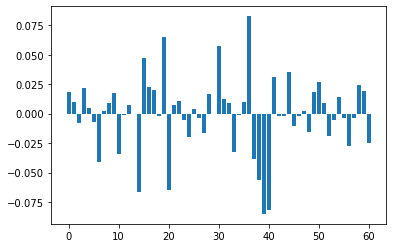

In [202]:
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### Multiclass Classification: KNN

In [203]:
# run a gridsearch to find the optimal hyperparameters
knn_model = KNeighborsClassifier()
knn_grid = [{'model__n_neighbors': [11, 19],
             'model__weights': ['uniform', 'distance'],
             'model__metric': ['euclidean', 'manhattan']}]
best_knn_model = model_train(ohe_X_train, y_train, knn_model, knn_grid, ohe_X_test, y_test)

Grid Search found the following optimal parameters: 
model__metric: 'euclidean'
model__n_neighbors: 11
model__weights: 'uniform'
pipeline test accuracy: 57.60%


In [204]:
best_model_knn = best_knn_model.best_estimator_
best_model_knn

Pipeline(steps=[('ss', StandardScaler()),
                ('model',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=11))])

In [205]:
print('Mean KNN Classifier Cross-Val Score (k=3):', \
      round(cross_val_score(best_knn_model, ohe_X_train, y_train, cv=3).mean(),3))

Mean KNN Classifier Cross-Val Score (k=3): 0.505


### Multiclass Classification: RandomForest

In [206]:
rfc_model = RandomForestClassifier()
rfc_grid = [{'model__bootstrap': [True, False],
             'model__n_estimators': [100, 400],
             'model__criterion': ['gini', 'entropy'],
             'model__max_features': ['auto', 'sqrt'],
             'model__max_depth': [None, 50],
             'model__min_samples_split': [5, 10],
             'model__min_samples_leaf': [1, 3]}]
model_rfc1 = model_train(ohe_X_train, y_train, rfc_model, rfc_grid, ohe_X_test, y_test)

Grid Search found the following optimal parameters: 
model__bootstrap: True
model__criterion: 'entropy'
model__max_depth: 50
model__max_features: 'auto'
model__min_samples_leaf: 3
model__min_samples_split: 10
model__n_estimators: 100
pipeline test accuracy: 60.80%


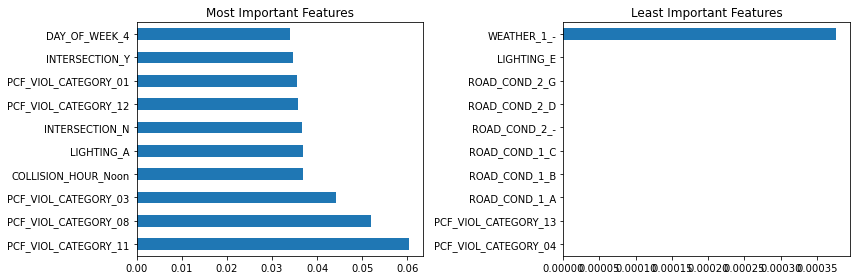

In [207]:
feat_importances = pd.Series(model_rfc1.best_estimator_.named_steps["model"].feature_importances_, index=ohe_X_train.columns)

fig, (ax1, ax2) = plt.subplots(1,2, figsize =(12,4))
feat_importances.nlargest(10).plot(kind='barh', ax=ax1)
feat_importances.nsmallest(10).plot(kind='barh', ax=ax2)
ax1.title.set_text('Most Important Features')
ax2.title.set_text('Least Important Features')
fig.tight_layout();

### Multiclass Classification: GradientBoosting

In [208]:
gradientboosting_model = GradientBoostingClassifier()
gradientboosting_grid = [{'model__loss':["deviance"],
                          'model__learning_rate': [0.01, 0.2],
                          'model__min_samples_split': [0.1, 0.5],
                          'model__min_samples_leaf': [0.1, 0.5],
                          'model__max_depth':[3, 8],
                          'model__max_features':["log2","sqrt"],
                          'model__criterion': ["friedman_mse",  "mae"],
                          'model__subsample':[0.5, 1.0],
                          'model__n_estimators':[10]}]

model_gradientboosting = model_train(ohe_X_train, y_train, gradientboosting_model, gradientboosting_grid, ohe_X_test, y_test)

Grid Search found the following optimal parameters: 
model__criterion: 'friedman_mse'
model__learning_rate: 0.01
model__loss: 'deviance'
model__max_depth: 3
model__max_features: 'log2'
model__min_samples_leaf: 0.5
model__min_samples_split: 0.5
model__n_estimators: 10
model__subsample: 0.5
pipeline test accuracy: 54.80%


In [209]:
feat_importances = pd.Series(model_gradientboosting.best_estimator_.named_steps["model"].feature_importances_, index=ohe_X_train.columns)
feat_importances.sort_values(ascending=False)

COLLISION_HOUR_Afternoon        0.0
PCF_VIOL_CATEGORY_03            0.0
PCF_VIOL_CATEGORY_05            0.0
PCF_VIOL_CATEGORY_06            0.0
PCF_VIOL_CATEGORY_07            0.0
PCF_VIOL_CATEGORY_08            0.0
PCF_VIOL_CATEGORY_09            0.0
PCF_VIOL_CATEGORY_10            0.0
PCF_VIOL_CATEGORY_11            0.0
PCF_VIOL_CATEGORY_12            0.0
PCF_VIOL_CATEGORY_13            0.0
PCF_VIOL_CATEGORY_17            0.0
PCF_VIOL_CATEGORY_18            0.0
PCF_VIOL_CATEGORY_21            0.0
PCF_VIOL_CATEGORY_22            0.0
ROAD_SURFACE_A                  0.0
ROAD_SURFACE_B                  0.0
ROAD_COND_1_A                   0.0
ROAD_COND_1_B                   0.0
ROAD_COND_1_C                   0.0
ROAD_COND_1_D                   0.0
ROAD_COND_1_H                   0.0
ROAD_COND_2_-                   0.0
ROAD_COND_2_D                   0.0
ROAD_COND_2_G                   0.0
LIGHTING_A                      0.0
LIGHTING_B                      0.0
LIGHTING_C                  

### Multiclass Classification: SVM

In [210]:
svm_model = SVC()
svm_grid = [{'model__C' : np.linspace(.1, 10, num=2),
        'model__gamma' : np.linspace(10**-3, 5, num=2),
        'model__kernel': ['linear','rbf', 'poly', 'sigmoid']}]

model_svm = model_train(ohe_X_train, y_train, svm_model, svm_grid, ohe_X_test, y_test)

Grid Search found the following optimal parameters: 
model__C: 10.0
model__gamma: 0.001
model__kernel: 'sigmoid'
pipeline test accuracy: 59.60%


In [211]:
# feat_importances = pd.Series(model_svm.best_estimator_.named_steps["model"].coef_, index=ohe_X_train.columns)
# feat_importances

### Multiclass Classification: Gaussian Naive Bayes

In [212]:
gnb_model = GaussianNB()
gnb_grid = [{'model__var_smoothing': np.logspace(0,-9, num=100)}]

model_gnb = model_train(ohe_X_train, y_train, gnb_model, gnb_grid, ohe_X_test, y_test)

Grid Search found the following optimal parameters: 
model__var_smoothing: 0.12328467394420659
pipeline test accuracy: 27.20%


[('PCF_VIOL_CATEGORY_21', 0.0328),
 ('LIGHTING_D', 0.0128),
 ('DIRECTION_W', 0.012),
 ('PCF_VIOL_CATEGORY_09', 0.008),
 ('PCF_VIOL_CATEGORY_08', 0.0072),
 ('PCF_VIOL_CATEGORY_18', 0.0056),
 ('DAY_OF_WEEK_3', 0.0048),
 ('DIRECTION_E', 0.0048),
 ('PCF_VIOL_CATEGORY_12', 0.0048),
 ('COLLISION_HOUR_Morning', 0.004)]

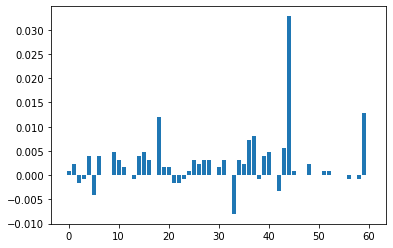

In [213]:
gnb_important_feats = permutation_importance(model_gnb, ohe_X_test, y_test)


feature_cols = np.array(ohe_X_train.columns)
feature_rank = {}
gnb_importance_array = np.array(gnb_important_feats.importances_mean)

# # summarize feature importance
for i,v in enumerate(gnb_importance_array):
    feature_rank[f'{feature_cols[i]}'] = round(v,5)

ranked_features = dict(sorted(feature_rank.items(), key=lambda item: item[1], reverse=True))
display(list(ranked_features.items())[:10])

# plot feature importance
plt.bar([x for x in range(len(gnb_importance_array))], gnb_importance_array)
plt.show()

# Conclusion

Given the results above from the Random Forest model and the findings garnered from the visualizations in the EDA process, there are several recommendations for next steps:

1. Explore different avenues and opportunities to reduce the speeds at which people are traveling - perhaps implementation of mechanisms to alert drivers when they are significantly above the speed limit.


2. Better education and/or road signage for drivers to combat improper turning

# Other Considerations

Taking a step further, the modeling can be done to predict multiple labels in the same model - such as predicting both the collision severity as well as the type of collision it would be. There is also an opportunity to explore other models and tuning of existing models to achieve a higher accuracy.

There are other aspects to further explore in this project - given the large number of labels and the fact that class imbalance in the dataset can occur as there are not that many severe collisions, given the total number of collisions. And the fact that most collisions happened during the daytime. This can skew the model's predictions and overrepresent certain collisions factors. Also, given that most collisions ended up in property damage, further data scrubbing can be conducts to over/undersample the dataset to fine-tune the algorithms.

### Multiclass/Multilabel Classification

In [215]:
def multilabel_multiclass_model(classifier, X_train, y_train, X_test, y_test):
    multi_classifier = MultiOutputClassifier(classifier,n_jobs=-1)
    multi_classifier.fit(X_train,y_train)
    
    # obtain subset accuracy: for each sample, each label was correctly predicted
    score = multi_classifier.score(X_test,y_test)
    return multi_classifier, score

In [216]:
def evaluation_metrics(classifier, X_test, y_test):
    y_pred = classifier.predict(ohe_X_test)
    y_test_arr = np.array(y_test)
    
    # recall score
    recall_nums = []
    for col in range(len(y_pred[0])):
        recall_nums.append(recall_score(y_test_arr[:, col], y_pred[:, col], average='weighted'))
    print(f'recall score: {np.average(recall_nums) : .2%}')
    
    # precision score
    precision_nums = []
    for col in range(len(y_pred[0])):
        precision_nums.append(precision_score(y_test_arr[:, col], y_pred[:, col], average='weighted'))
    print(f'precision score: {np.average(precision_nums) : .2%}')
    
    # f1_score
    f1_nums = []
    for col in range(len(y_pred[0])):
        f1_nums.append(f1_score(y_test_arr[:, col], y_pred[:, col], average='weighted'))
    print(f'f1_score: {np.average(f1_nums) : .2%}')

In [217]:
def multilabel_model_testing(model, X_train, y_train, X_test, y_test):
    best_score = 0
    iterations = 0
    best_classifier = None
    
    while iterations < 5:
        classifier, score = multilabel_multiclass_model(model, X_train, y_train, X_test, y_test)
        if score > best_score:
            best_classifier = classifier
            best_score = score
        iterations+=1
    print(f'test accuracy: {best_score : .2%}')
    evaluation_metrics(best_classifier, ohe_X_test, y_test)
    return model

In [218]:
# establish baseline of predicting the correct combination with a random guess 
num_vals = []
for col in np.array(labels.columns):
    num_vals.append(len(labels[f'{col}'].value_counts()))
    
odds = 1/np.prod(np.array(num_vals)) 
baseline = 'baseline probability: {0:.2f}%'.format(odds * 100)
baseline

'baseline probability: 20.00%'

In [219]:
# examine multiclass-multioutput classifiers
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier()
extra_tree = ExtraTreeClassifier()
extra_trees = ExtraTreesClassifier()
ran_forest = RandomForestClassifier()
baseline_models = [knn,tree,extra_tree, extra_trees, ran_forest]

for model in baseline_models:
    print(model)
    print('---')
    multilabel_model_testing(model, ohe_X_train, y_train, ohe_X_test, y_test)
    print('\n')

KNeighborsClassifier()
---
test accuracy:  51.60%
recall score:  51.60%
precision score:  46.54%
f1_score:  48.66%


DecisionTreeClassifier()
---
test accuracy:  46.00%
recall score:  46.00%
precision score:  47.29%
f1_score:  46.58%


ExtraTreeClassifier()
---
test accuracy:  45.60%
recall score:  45.60%
precision score:  44.35%
f1_score:  44.96%


ExtraTreesClassifier()
---
test accuracy:  50.00%
recall score:  50.00%
precision score:  48.41%
f1_score:  49.15%


RandomForestClassifier()
---
test accuracy:  53.60%
recall score:  53.60%
precision score:  51.46%
f1_score:  52.20%




In [220]:
from sklearn.datasets import make_multilabel_classification

x, y = make_multilabel_classification(n_samples=5000, n_features=10,
                                      n_classes=2, n_labels=2, random_state=0)

In [221]:
y

array([[1, 1],
       [0, 1],
       [1, 1],
       ...,
       [1, 1],
       [1, 1],
       [1, 1]])

In [222]:
xtrain, xtest, ytrain, ytest=train_test_split(x, y, train_size=0.95, random_state=0)
print(len(xtest))
# 250 

250


250

In [223]:
svc = SVC(gamma="scale")
model = MultiOutputClassifier(estimator=svc)

model.fit(xtrain, ytrain)
print(model.score(xtrain, ytrain))
# 0.8688421052631579 

0.8688421052631579


0.8688421052631579

In [224]:
yhat = model.predict(xtest)

auc_y1 = roc_auc_score(ytest[:,0],yhat[:,0])
auc_y2 = roc_auc_score(ytest[:,1],yhat[:,1])

print("ROC AUC y1: %.4f, y2: %.4f" % (auc_y1, auc_y2))
# ROC AUC y1: 0.9206, y2: 0.9202

SyntaxError: invalid syntax (<ipython-input-224-1768b8930a07>, line 7)

In [ ]:
cm_y1 = confusion_matrix(ytest[:,0],yhat[:,0])
cm_y2 = confusion_matrix(ytest[:,1],yhat[:,1])
 
print(cm_y1)
# [[ 80   8]
#  [ 11 151]]
print(cm_y2)
# [[ 77   9]
#  [  9 155]] 

In [ ]:
cr_y1 = classification_report(ytest[:,0],yhat[:,0])
cr_y1 = classification_report(ytest[:,0],yhat[:,0])